**Assessment of Random Forest (RF) for the classification of oil palm plantations.**

Adrià Descals - a.descals@creaf.uab.cat /
CREAF - Centre de Recerca Ecològica i Aplicacions Forestals


In [0]:
# Initialize Google Earth Engine
!pip install earthengine-api
!earthengine authenticate

import ee
try:
  ee.Initialize()
  print('The Earth Engine package initialized successfully!')
except ee.EEException as e:
  print('The Earth Engine package failed to initialize!')
except:
    print("Unexpected error:", sys.exc_info()[0])
    raise

# Import libraries and training data

In [0]:
import numpy as np
import time
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from shapely.geometry import shape
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import r2_score
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix

# Function to Convert Feature Classes to Pandas Dataframe
def fc2df(fc):
    features = fc.getInfo()['features']
    dictarr = []
    for f in features:
        attr = f['properties']
        dictarr.append(attr)

    return pd.DataFrame(dictarr)


In [0]:
# load training dataset
assetID = 'users/adriadescals/shared/points_2019_05_27_1311X_Riau_paperPoints'
tableGEE = ee.FeatureCollection(assetID);
tableGEElist = tableGEE.toList(100000)

tableGEE1 = ee.FeatureCollection(tableGEElist.slice(0, 4000))
df =  fc2df(tableGEE1)

In [20]:
# change non-valid number to nan
df = df.replace([-9], np.nan).dropna()
print('Number of samples: ' + str(len(df)))

Number of samples: 3448


In [6]:
# Distribution of classes
print()
print('Class1: ' + str(sum(df.Class5==1)) + ' points - ' + str(round(sum(df.Class5==1)/len(df.Class5)*100,2)) + '%')
print('Class2: ' + str(sum(df.Class5==2)) + ' points - ' + str(round(sum(df.Class5==2)/len(df.Class5)*100,2)) + '%')
print('Class3: ' + str(sum(df.Class5==3)) + ' points - ' + str(round(sum(df.Class5==3)/len(df.Class5)*100,2)) + '%')
print('Class4: ' + str(sum(df.Class5==4)) + ' points - ' + str(round(sum(df.Class5==4)/len(df.Class5)*100,2)) + '%')
print('Class5: ' + str(sum(df.Class5==5)) + ' points - ' + str(round(sum(df.Class5==5)/len(df.Class5)*100,2)) + '%')


Class1: 621 points - 18.01%
Class2: 727 points - 21.08%
Class3: 1016 points - 29.47%
Class4: 244 points - 7.08%
Class5: 840 points - 24.36%


In [8]:
# Create variable with predictive data and display all feature names
Xall = df.copy()
Xall = Xall.drop(['mean','Class','Class2','Class3','Class4','Class5','folder','longitude','latitude','zone'],axis='columns')
allBands = Xall.columns.tolist()
print(Xall.columns.values)

folders = df.folder

['B11' 'B11_1' 'B11_asm' 'B11_contrast' 'B11_corr' 'B11_dent' 'B11_diss'
 'B11_dvar' 'B11_ent' 'B11_idm' 'B11_imcorr1' 'B11_imcorr2' 'B11_inertia'
 'B11_maxcorr' 'B11_prom' 'B11_savg' 'B11_sent' 'B11_shade' 'B11_svar'
 'B11_var' 'B12' 'B12_1' 'B2' 'B2_1' 'B3' 'B3_1' 'B4' 'B4_1' 'B4_2'
 'B4_asm' 'B4_asm_1' 'B4_contrast' 'B4_contrast_1' 'B4_corr' 'B4_corr_1'
 'B4_dent' 'B4_dent_1' 'B4_diss' 'B4_diss_1' 'B4_dvar' 'B4_dvar_1'
 'B4_ent' 'B4_ent_1' 'B4_idm' 'B4_idm_1' 'B4_imcorr1' 'B4_imcorr1_1'
 'B4_imcorr2' 'B4_imcorr2_1' 'B4_inertia' 'B4_inertia_1' 'B4_maxcorr'
 'B4_maxcorr_1' 'B4_prom' 'B4_prom_1' 'B4_savg' 'B4_savg_1' 'B4_sent'
 'B4_sent_1' 'B4_shade' 'B4_shade_1' 'B4_svar' 'B4_svar_1' 'B4_var'
 'B4_var_1' 'B6' 'B6_1' 'B7' 'B7_1' 'B7_asm' 'B7_contrast' 'B7_corr'
 'B7_dent' 'B7_diss' 'B7_dvar' 'B7_ent' 'B7_idm' 'B7_imcorr1' 'B7_imcorr2'
 'B7_inertia' 'B7_maxcorr' 'B7_prom' 'B7_savg' 'B7_sent' 'B7_shade'
 'B7_svar' 'B7_var' 'B8' 'B8A' 'B8A_1' 'B8_1' 'B8_asm' 'B8_contrast'
 'B8_corr' 'B8_d

In [0]:
# Complete name of the features
bands_completeName = ['B11_original_ksize0', 'B11_smooth_ksize2', 'B11_asm_ksize10', 'B11_contrast_ksize10', 'B11_corr_ksize10', 'B11_dent_ksize10', 'B11_diss_ksize10',
 'B11_dvar_ksize10', 'B11_ent_ksize10', 'B11_idm_ksize10', 'B11_imcorr_ksize10', 'B11_imcorr_ksize30', 'B11_inertia_ksize10',
 'B11_maxcorr_ksize10', 'B11_prom_ksize10', 'B11_savg_ksize10', 'B11_sent_ksize10', 'B11_shade_ksize10', 'B11_svar_ksize10',
 'B11_var_ksize10', 'B12_original_ksize0', 'B12_smooth_ksize2', 'B2_original_ksize0', 'B2_1_original_ksize0', 'B3_original_ksize0', 'B3_smooth_ksize2', 'B4_original_ksize0', 'B4_smooth_ksize2', 'B4_smooth_ksize2',
 'B4_asm_ksize10', 'B4_asm_ksize30', 'B4_contrast_ksize10', 'B4_contrast_ksize30', 'B4_corr_ksize10', 'B4_corr_ksize30',
 'B4_dent_ksize10', 'B4_dent_ksize30', 'B4_diss_ksize10', 'B4_diss_ksize30', 'B4_dvar_ksize10', 'B4_dvar_ksize30',
 'B4_ent_ksize10', 'B4_ent_ksize30', 'B4_idm_ksize10', 'B4_idm_ksize30', 'B4_imcorr1_ksize10', 'B4_imcorr1_ksize30',
 'B4_imcorr2_ksize10', 'B4_imcorr2_ksize30', 'B4_inertia_ksize10', 'B4_inertia_ksize30', 'B4_maxcorr_ksize10',
 'B4_maxcorr_ksize30', 'B4_prom_ksize10', 'B4_prom_ksize30', 'B4_savg_ksize10', 'B4_savg_ksize30', 'B4_sent_ksize10',
 'B4_sent_ksize30', 'B4_shade_ksize10', 'B4_shade_ksize30', 'B4_svar_ksize10', 'B4_svar_ksize30', 'B4_var_ksize10',
 'B4_var_ksize30', 'B6_original_ksize10', 'B6_smooth_ksize2', 'B7_original_ksize10', 'B7_smooth_ksize2', 'B7_asm_ksize10', 'B7_contrast_ksize10', 'B7_corr_ksize10',
 'B7_dent_ksize10', 'B7_diss_ksize10', 'B7_dvar_ksize10', 'B7_ent_ksize10', 'B7_idm_ksize10', 'B7_imcorr1_ksize30', 'B7_imcorr2_ksize30',
 'B7_inertia_ksize10', 'B7_maxcorr_ksize10', 'B7_prom_ksize10', 'B7_savg_ksize10', 'B7_sent_ksize10', 'B7_shade_ksize10',
 'B7_svar_ksize10', 'B7_var_ksize10', 'B8_original_ksize0', 'B8A_original_ksize0', 'B8A_smooth_ksize2', 'B8_smooth_ksize2', 'B8_asm_ksize10', 'B8_contrast_ksize10',
 'B8_corr_ksize10', 'B8_dent_ksize10', 'B8_diss_ksize10', 'B8_dvar_ksize10', 'B8_ent_ksize10', 'B8_idm_ksize10', 'B8_imcorr1_ksize10',
 'B8_imcorr2_ksize10', 'B8_inertia_ksize10', 'B8_maxcorr_ksize10', 'B8_prom_ksize10', 'B8_savg_ksize10', 'B8_sent_ksize10',
 'B8_shade_ksize10', 'B8_svar_ksize10', 'B8_var_ksize10', 'evi_asm_ksize10', 'evi_asm_ksize30', 'evi_contrast_ksize10',
 'evi_contrast_ksize30', 'evi_corr_ksize10', 'evi_corr_ksize30', 'evi_dent_ksize10', 'evi_dent_ksize30',
 'evi_diss_ksize10', 'evi_diss_ksize30', 'evi_dvar_ksize10', 'evi_dvar_ksize30', 'evi_ent_ksize10', 'evi_ent_ksize30',
 'evi_idm_ksize10', 'evi_idm_ksize30', 'evi_imcorr1_ksize10', 'evi_imcorr1_ksize30', 'evi_imcorr2_ksize10',
 'evi_imcorr2_ksize30', 'evi_inertia_ksize10', 'evi_inertia_ksize30', 'evi_maxcorr_ksize10',
 'evi_maxcorr_ksize30', 'evi_prom_ksize10', 'evi_prom_ksize30', 'evi_savg_ksize10', 'evi_savg_ksize30',
 'evi_sent_ksize10', 'evi_sent_ksize30', 'evi_shade_ksize10', 'evi_shade_ksize30', 'evi_svar_ksize10', 'evi_svar_ksize30',
 'evi_var_ksize10', 'evi_var_ksize30','random', 'vh_original_ksize10', 'vh_hist_ksize2',
 'vh_hist_smooth_ksize5', 'vh_smooth_ksize5', 'vh_smooth_ksize5_asm_ksize10',
 'vh_smooth_ksize5_contrast_ksize10', 'vh_smooth_ksize5_corr_ksize10', 'vh_smooth_ksize5_dent_ksize10',
 'vh_smooth_ksize5_diss_ksize10', 'vh_smooth_ksize5_dvar', 'vh_smooth_ksize5_ent_ksize10',
 'vh_smooth_ksize5_idm_ksize10', 'vh_smooth_ksize5_imcorr1_ksize10', 'vh_smooth_ksize5_imcorr2',
 'vh_smooth_ksize5_inertia_ksize10', 'vh_smooth_ksize5_maxcorr_ksize10',
 'vh_smooth_ksize5_prom_ksize10', 'vh_smooth_ksize5_savg_ksize10', 'vh_smooth_ksize5_sent_ksize10',
 'vh_smooth_ksize5_shade_ksize10', 'vh_smooth_ksize5_svar_ksize10', 'vh_smooth_ksize5_var_ksize10',
 'vh_smooth_ksize10', 'vv_original_ksize0', 'vv_hist_smooth_ksize2', 'vv_hist_smooth_ksize5',
 'vv_smooth_ksize5', 'vv_smooth_ksize5_asm_ksize10', 'vv_smooth_ksize5_contrast_ksize10',
 'vv_smooth_ksize5_corr_ksize10', 'vv_smooth_ksize5_dent_ksize10', 'vv_smooth_ksize5_diss_ksize10',
 'vv_smooth_ksize5_dvar_ksize10', 'vv_smooth_ksize5_ent_ksize10', 'vv_smooth_ksize5_idm_ksize10',
 'vv_smooth_ksize5_imcorr1_ksize10', 'vv_smooth_ksize5_imcorr2_ksize10',
 'vv_smooth_ksize5_inertia_ksize10', 'vv_smooth_ksize5_maxcorr_ksize10',
 'vv_smooth_ksize5_prom_ksize10', 'vv_smooth_ksize5_savg_ksize10', 'vv_smooth_ksize5_sent_ksize10',
 'vv_smooth_ksize5_shade_ksize10', 'vv_smooth_ksize5_svar_ksize10', 'vv_smooth_ksize5_var_ksize10',
 'vv_smooth_ksize10']

features_label = np.array(bands_completeName)

In [0]:
# Create set of variables - i.e. depending on the satellite source
bandsS1 = ['t0_vh', 't0_vh_hist_smoothed', 't0_vh_hist_smoothed2', 't0_vh_smoothed2', 't0_vh_smoothed2_asm', 't0_vh_smoothed2_contrast', 't0_vh_smoothed2_corr', 't0_vh_smoothed2_dent', 't0_vh_smoothed2_diss', 't0_vh_smoothed2_dvar', 't0_vh_smoothed2_ent', 't0_vh_smoothed2_idm', 't0_vh_smoothed2_imcorr1', 't0_vh_smoothed2_imcorr2', 't0_vh_smoothed2_inertia', 't0_vh_smoothed2_maxcorr', 't0_vh_smoothed2_prom', 't0_vh_smoothed2_savg', 't0_vh_smoothed2_sent', 't0_vh_smoothed2_shade', 't0_vh_smoothed2_svar', 't0_vh_smoothed2_var', 't0_vh_smoothed3', 't0_vv', 't0_vv_hist_smoothed', 't0_vv_hist_smoothed2', 't0_vv_smoothed2', 't0_vv_smoothed2_asm', 't0_vv_smoothed2_contrast', 't0_vv_smoothed2_corr', 't0_vv_smoothed2_dent', 't0_vv_smoothed2_diss', 't0_vv_smoothed2_dvar', 't0_vv_smoothed2_ent', 't0_vv_smoothed2_idm', 't0_vv_smoothed2_imcorr1', 't0_vv_smoothed2_imcorr2', 't0_vv_smoothed2_inertia', 't0_vv_smoothed2_maxcorr', 't0_vv_smoothed2_prom', 't0_vv_smoothed2_savg', 't0_vv_smoothed2_sent', 't0_vv_smoothed2_shade', 't0_vv_smoothed2_svar', 't0_vv_smoothed2_var', 't0_vv_smoothed3']
bandsS2 =['B11', 'B11_1', 'B11_asm', 'B11_contrast', 'B11_corr', 'B11_dent', 'B11_diss', 'B11_dvar', 'B11_ent', 'B11_idm', 'B11_imcorr1', 'B11_imcorr2', 'B11_inertia', 'B11_maxcorr', 'B11_prom', 'B11_savg', 'B11_sent', 'B11_shade', 'B11_svar', 'B11_var', 'B12', 'B12_1', 'B2', 'B2_1', 'B3', 'B3_1', 'B4', 'B4_1', 'B4_2', 'B4_asm', 'B4_asm_1', 'B4_contrast', 'B4_contrast_1', 'B4_corr', 'B4_corr_1', 'B4_dent', 'B4_dent_1', 'B4_diss', 'B4_diss_1', 'B4_dvar', 'B4_dvar_1', 'B4_ent', 'B4_ent_1', 'B4_idm', 'B4_idm_1', 'B4_imcorr1', 'B4_imcorr1_1', 'B4_imcorr2', 'B4_imcorr2_1', 'B4_inertia', 'B4_inertia_1', 'B4_maxcorr', 'B4_maxcorr_1', 'B4_prom', 'B4_prom_1', 'B4_savg', 'B4_savg_1', 'B4_sent', 'B4_sent_1', 'B4_shade', 'B4_shade_1', 'B4_svar', 'B4_svar_1', 'B4_var', 'B4_var_1', 'B6', 'B6_1', 'B7', 'B7_1', 'B7_asm', 'B7_contrast', 'B7_corr', 'B7_dent', 'B7_diss', 'B7_dvar', 'B7_ent', 'B7_idm', 'B7_imcorr1', 'B7_imcorr2', 'B7_inertia', 'B7_maxcorr', 'B7_prom', 'B7_savg', 'B7_sent', 'B7_shade', 'B7_svar', 'B7_var', 'B8', 'B8A', 'B8A_1', 'B8_1', 'B8_asm', 'B8_contrast', 'B8_corr', 'B8_dent', 'B8_diss', 'B8_dvar', 'B8_ent', 'B8_idm', 'B8_imcorr1', 'B8_imcorr2', 'B8_inertia', 'B8_maxcorr', 'B8_prom', 'B8_savg', 'B8_sent', 'B8_shade', 'B8_svar', 'B8_var', 'evi_asm', 'evi_asm_1', 'evi_contrast', 'evi_contrast_1', 'evi_corr', 'evi_corr_1', 'evi_dent', 'evi_dent_1', 'evi_diss', 'evi_diss_1', 'evi_dvar', 'evi_dvar_1', 'evi_ent', 'evi_ent_1', 'evi_idm', 'evi_idm_1', 'evi_imcorr1', 'evi_imcorr1_1', 'evi_imcorr2', 'evi_imcorr2_1', 'evi_inertia', 'evi_inertia_1', 'evi_maxcorr', 'evi_maxcorr_1', 'evi_prom', 'evi_prom_1', 'evi_savg', 'evi_savg_1', 'evi_sent', 'evi_sent_1', 'evi_shade', 'evi_shade_1', 'evi_svar', 'evi_svar_1', 'evi_var', 'evi_var_1']
bandsNoFeatures =['B11', 'B12', 'B2', 'B3', 'B4', 'B6', 'B7', 'B8', 'B8A','t0_vh','t0_vv','t0_vh_hist_smoothed','t0_vv_hist_smoothed']

# CROSS VALIDATION 1TRAIN 9TEST

In [13]:
# CROSS VALIDATION 1TRAIN 9TEST VS. 9TRAIN 1TEST

# set variables 0 - all bands
bands = allBands

# set variables 1 - original bands of Sentinel-1 and Sentinel-2
bands = bandsNoFeatures

# set variables 2 - bands from permutation analysis
bands = ['B4_inertia',
 'B4_asm_1',
 'B4_1',
 't0_vv_hist_smoothed',
 't0_vh_hist_smoothed2',
 'B4_dvar_1',
 'B7_savg',
 'B7_1',
 't0_vv_smoothed3',
 'evi_sent_1',
 'B8_1',
 'evi_savg_1',
 'B4_savg',
 'evi_ent_1',
 't0_vh_smoothed3',
 'B12',
 't0_vv_hist_smoothed2',
 't0_vv_smoothed2_savg',
 't0_vh_smoothed2_savg',
 't0_vv_smoothed2',
 't0_vh',
 'B11_savg',
 'B11_1',
 't0_vh_smoothed2',
 'B4_corr_1',
 'evi_corr_1']

# set variables 3 - bands from gini importance
bands = ['B8_corr', 'evi_savg_1', 'B4_1', 'B4_savg_1', 'B7_savg', 'B8_savg', 'B4_savg',
 'evi_sent_1', 't0_vv_hist_smoothed', 't0_vh', 't0_vv_smoothed2_savg',
 't0_vh_hist_smoothed', 't0_vv_smoothed2', 'B12', 'evi_corr_1', 'B11', 'B12_1',
 't0_vh_hist_smoothed2', 'B4_corr_1', 't0_vv_hist_smoothed2',
 't0_vh_smoothed2_savg', 't0_vv_smoothed3', 'B11_savg', 't0_vh_smoothed3',
 'B11_1', 't0_vh_smoothed2']

# set variables 4 - bands from sequential feature selection (all 26 bands)
bands = ['B11_savg', 't0_vh_smoothed2', 't0_vv_hist_smoothed2', 'B4_corr_1', 'B8_savg',
                  'B4_dvar_1', 'evi_corr_1', 't0_vh_hist_smoothed2', 't0_vv_smoothed2', 'B7_1',
                  't0_vv_hist_smoothed', 't0_vv_smoothed2_imcorr1', 'B4_savg_1', 'B4_shade_1', 'B7_savg',
                  'B4_contrast_1', 'B11_maxcorr', 't0_vv_smoothed2_prom', 'evi_savg_1', 't0_vh_smoothed2_savg',
                  'B4_maxcorr', 'B11_1', 'B4_maxcorr_1', 'B7_sent', 'evi_savg', 't0_vv_smoothed2_shade']


# set variables 4 - bands from sequential feature selection (15 bands)
bands = ['B11_savg', 't0_vh_smoothed2', 't0_vv_hist_smoothed2', 'B4_corr_1', 'B8_savg', 'B4_dvar_1',
         'evi_corr_1', 't0_vh_hist_smoothed2', 't0_vv_smoothed2', 'B7_1', 't0_vv_hist_smoothed',
         't0_vv_smoothed2_imcorr1', 'B4_savg_1', 'B4_shade_1', 'B7_savg']


#################################
X = Xall[bands].copy()

for cc in range(3): 
  if cc == 0: # classification setup I
    print('classification setup I')
    y = df.Class5.copy()
    classSize = 5
  elif cc == 1: # classification setup II
    print('classification setup II')
    y = df.Class5.copy()
    y[y==2]=1
    y[y==4]=3   
    classSize = 3
  elif cc == 2: # classification setup III
    print('classification setup III')
    y = df.Class5.copy()
    y[y==2]=5
    y[y==4]=5
    y[y==3]=1  
    classSize= 2
    
  CM = np.empty((classSize,classSize,)) # allocate confusion matrices
  CM[:] = 0
    
  millis1 = int(round(time.time() * 1000))
  for kk in [0]: #in [1, 0]: # kk = 0 => 90% test 10% train // kk = 1 => 10% test 90% train
    acc = np.empty((10,1,)) # allocate overall accuracy
    acc[:] = np.nan
    kappa = np.empty((10,1,)) # allocate kappa
    kappa[:] = np.nan

    for ii in range(0,10):
      jj = ii+1
      if kk:
        X_train = X[folders!=jj]
        y_train = y[folders!=jj]
        X_test = X[folders==jj]
        y_test = y[folders==jj]
      else:
        X_train = X[folders==jj]
        y_train = y[folders==jj]
        X_test = X[folders!=jj]
        y_test = y[folders!=jj]
      
      # initialize RF
      model = RandomForestClassifier(n_estimators=50, random_state=35,min_samples_split=2,min_samples_leaf=3,max_features='sqrt',oob_score=0,
                                    warm_start=True)
      # fit RF
      model = model.fit(X_train, y_train)

      # allocate results
      acc_ii = model.score(X_test, y_test)
      acc[ii] = acc_ii

      kappa_ii = cohen_kappa_score(model.predict(X_test), y_test)
      kappa[ii] = kappa_ii
      
      y_predicted = model.predict(X_test)
      cm = confusion_matrix(y_test, y_predicted)
      CM = CM+cm
      
    # Average the confusion matrices
    if cc == 0:
      CM1 = (CM/10).astype(np.int32)
    elif cc == 1:
      CM2 = (CM/10).astype(np.int32)
    elif cc == 2:
      CM3 = (CM/10).astype(np.int32)

    # display results
    if kk:
      print("9fold train OA = %.3f±%.3f" % (acc.mean(), acc.std()*2))
      print("9fold train kappa = %.3f±%.3f" % (kappa.mean(), kappa.std()*2))
      print(" ")
    else:
      print("1fold train OA = %.3f±%.3f" % (acc.mean(), acc.std()*2))
      print("1fold train kappa = %.3f±%.3f" % (kappa.mean(), kappa.std()*2))

  millis2 = int(round(time.time() * 1000))
#   print((millis2-millis1)/1000)
  print(" ")



classification setup I
1fold train OA = 0.901±0.017
1fold train kappa = 0.871±0.022
 
classification setup II
1fold train OA = 0.925±0.012
1fold train kappa = 0.885±0.018
 
classification setup III
1fold train OA = 0.954±0.014
1fold train kappa = 0.908±0.029
 


PLOT CONFUSION MATRICES and UA/PA ACCURACIES

[[475.   7.  66.   1.   9.]
 [  8. 621.  10.   4.   9.]
 [ 44.   3. 840.   6.  20.]
 [  0.  13.  48. 140.  16.]
 [  0.  14.  15.   7. 718.]]
 
USERS ACCURACY
0.9013282732447818
0.9437689969604863
0.8580183861082737
0.8860759493670886
0.9300518134715026
 
PRODUCERS ACCURACY
0.8512544802867383
0.9524539877300614
0.9200438116100766
0.6451612903225806
0.9522546419098143
 


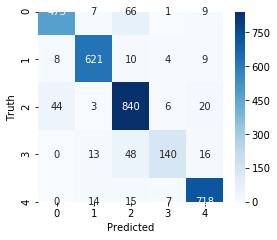

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(4.15,3.5))
sn.heatmap(CM1,annot=True,cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

cm = CM1.astype(np.float)
print(cm)
print(' ')
print('USERS ACCURACY')
print((cm.transpose()[0][0])/(sum(cm.transpose()[0])))
print((cm.transpose()[1][1])/(sum(cm.transpose()[1])))
print((cm.transpose()[2][2])/(sum(cm.transpose()[2])))
print((cm.transpose()[3][3])/(sum(cm.transpose()[3])))
print((cm.transpose()[4][4])/(sum(cm.transpose()[4])))
print(' ')
print('PRODUCERS ACCURACY')
print((cm[0][0])/(sum(cm[0])))
print((cm[1][1])/(sum(cm[1])))
print((cm[2][2])/(sum(cm[2])))
print((cm[3][3])/(sum(cm[3])))
print((cm[4][4])/(sum(cm[4])))
print(' ')


# plt.savefig('CM1.svg')
# files.download('CM1.svg')



[[1124   72   16]
 [  67 1043   23]
 [  19   34  702]]
 
USERS ACCURACY
0.9289256198347108
0.9077458659704091
0.9473684210526315
 
PRODUCERS ACCURACY
0.9273927392739274
0.9205648720211828
0.9298013245033112
 


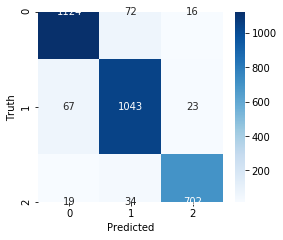

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(4.15,3.5))
sn.heatmap(CM2,annot=True,cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

cm = CM2
print(cm)
print(' ')
print('USERS ACCURACY')
print((cm.transpose()[0][0])/(sum(cm.transpose()[0])))
print((cm.transpose()[1][1])/(sum(cm.transpose()[1])))
print((cm.transpose()[2][2])/(sum(cm.transpose()[2])))
print(' ')
print('PRODUCERS ACCURACY')
print((cm[0][0])/(sum(cm[0])))
print((cm[1][1])/(sum(cm[1])))
print((cm[2][2])/(sum(cm[2])))
print(' ')

# plt.savefig('CM2.svg')
# files.download('CM2.svg')

[[1384   89]
 [  53 1576]]
 
USERS ACCURACY
0.9631176061238692
0.9465465465465466
 
PRODUCERS ACCURACY
0.9395790902919212
0.9674647022713321
 


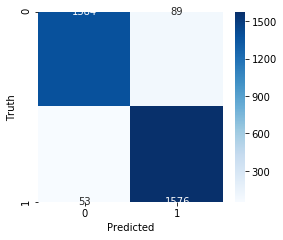

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(4.15,3.5))
sn.heatmap(CM3,annot=True,cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

cm = CM3
print(cm)
print(' ')
print('USERS ACCURACY')
print((cm.transpose()[0][0])/(sum(cm.transpose()[0])))
print((cm.transpose()[1][1])/(sum(cm.transpose()[1])))
print(' ')
print('PRODUCERS ACCURACY')
print((cm[0][0])/(sum(cm[0])))
print((cm[1][1])/(sum(cm[1])))
print(' ')

# plt.savefig('CM3.svg')
# files.download('CM3.svg')

# Gini index - Feature selection

In [0]:
bands = allBands

# prepare data
X = Xall[bands].copy()
y = df.Class5.copy()

X_train = X.copy()
y_train = y.copy()
X_test = X.copy()
y_test = y.copy()

# fit a RF with all bands
modelGINI = RandomForestClassifier(n_estimators=50, random_state=35,min_samples_split=2,min_samples_leaf=3,max_features='sqrt',oob_score=0,
                              warm_start=True)
modelGINI = modelGINI.fit(X_train, y_train)


In [0]:
# take the most relevant features
features = X.columns.values
importances = modelGINI.feature_importances_
indices = np.argsort(importances)

print(features[indices][-26:])

['B8_corr' 'evi_savg_1' 'B4_1' 'B4_savg_1' 'B7_savg' 'B8_savg' 'B4_savg'
 'evi_sent_1' 't0_vv_hist_smoothed' 't0_vh' 't0_vv_smoothed2_savg'
 't0_vh_hist_smoothed' 't0_vv_smoothed2' 'B12' 'evi_corr_1' 'B11' 'B12_1'
 't0_vh_hist_smoothed2' 'B4_corr_1' 't0_vv_hist_smoothed2'
 't0_vh_smoothed2_savg' 't0_vv_smoothed3' 'B11_savg' 't0_vh_smoothed3'
 'B11_1' 't0_vh_smoothed2']


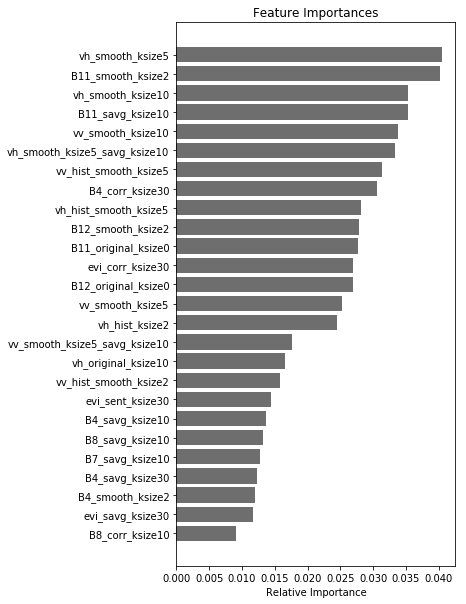

In [0]:
# plot figure
plt.rcParams['figure.figsize'] = [5, 10]
plt.title('Feature Importances')
plt.barh(range(len(indices[-26:])), importances[indices][-26:], color='#6E6E6E', align='center')
plt.yticks(range(len(indices[-26:])), features_label[indices][-26:])
plt.xlabel('Relative Importance')

# download image as svg
plt.savefig('fs1_gini.svg')
files.download('fs1_gini.svg')

# Sequential Feature Selection - RF cross-validated 10%train/90%test

In [0]:
# FIND THE FIRST FEATURE, WITH THE HIGHEST KAPPA
allBands = Xall.columns.tolist()
# print(allBands)

y2 = df.Class5.copy()

acc_all = np.empty((len(allBands),1,))
acc_all[:] = np.nan


for ff in range(0,len(allBands)):
    # split with folders


    targetBand = allBands[ff]
#     targetBand = ['B11',targetBand]
#     print(targetBand)

    X2 = Xall[targetBand].copy()
    X2 = np.array([X2]).T       

    acc = np.empty((10,1,))
    acc[:] = np.nan

    for ii in range(0,10):
      jj = ii+1
      X_train = X2[folders==jj]
      y_train = y2[folders==jj]
      X_test = X2[folders!=jj]
      y_test = y2[folders!=jj]
      model = RandomForestClassifier(n_estimators=40, random_state=35,min_samples_split=2,min_samples_leaf=3,max_features='sqrt',oob_score=0)
      model = model.fit(X_train, y_train)
      acc_ii=kappa_ii = cohen_kappa_score(model.predict(X_test), y_test)
      acc[ii] = acc_ii

#     print(acc.mean())
    print(str(ff)+'/'+str(len(allBands)))

    acc_all[ff] = acc.mean()
    #print(acc.std()*2)
    

In [0]:
# take the name of the first feature
features = X.columns.values
firstBands = allBands[np.argmax(acc_all)]

In [0]:
# FIND OUT THE 26 MOST RELEVANT FEATURES
selected_bands = [firstBands];
bands2 = allBands2.copy()
bands2.remove(firstBands)
y2 = df.Class5.copy()

for iter in range(0,25):

  acc_all = np.empty((len(bands2),1,))
  acc_all[:] = np.nan

  #print(listTarget)

  for ff in range(0,len(bands2)):
      # split with folders
      
      
      listTarget = [bands2[ff]]
      listTarget.extend(selected_bands)
#       print(listTarget)
      
      X2 = df[listTarget]
      
      #y2= (df['Class']<5)


      acc = np.empty((10,1,))
      acc[:] = np.nan
      
      for ii in range(0,10):
        jj = ii+1
        X_train = X2[folders==jj]
        y_train = y2[folders==jj]
        X_test = X2[folders!=jj]
        y_test = y2[folders!=jj]
        model = RandomForestClassifier(n_estimators=40, random_state=35,min_samples_split=2,min_samples_leaf=3,max_features='sqrt',oob_score=0)
        model = model.fit(X_train, y_train)
        acc_ii=kappa_ii = cohen_kappa_score(model.predict(X_test), y_test)
        acc[ii] = acc_ii
      
#       print(acc.mean())

      acc_all[ff] = acc.mean()
      #print(acc.std()*2)

  bandSelected = bands2[np.argmax(acc_all)]
  bands2.remove(bandSelected)
  selected_bands.append(bandSelected)
  selectedKappa[1+iter] = max(acc_all)
  print(selected_bands)
  print(selectedKappa)

In [0]:
# RESULTS OF THE SFS (run from here)

selected_bands_short_name = ['B11_savg', 't0_vh_smoothed2', 't0_vv_hist_smoothed2', 'B4_corr_1', 'B8_savg', 'B4_dvar_1', 'evi_corr_1', 't0_vh_hist_smoothed2', 't0_vv_smoothed2', 'B7_1', 't0_vv_hist_smoothed', 't0_vv_smoothed2_imcorr1', 'B4_savg_1', 'B4_shade_1', 'B7_savg', 'B4_contrast_1', 'B11_maxcorr', 't0_vv_smoothed2_prom', 'evi_savg_1', 't0_vh_smoothed2_savg', 'B4_maxcorr', 'B11_1', 'B4_maxcorr_1', 'B7_sent', 'evi_savg', 't0_vv_smoothed2_shade']
selected_bands = ['B11_savg_ksize10', 'vh_smooth_ksize5', 'vv_hist_smooth_ksize5', 'B4_corr_ksize30', 'B8_savg_ksize10',
 'B4_dvar_ksize30', 'evi_corr_ksize30', 'vh_hist_smooth_ksize5', 'vv_smooth_ksize5', 'B7_ksize30',
 'vv_hist_smoothed_ksize2', 'vv_smooth_ksize5_imcorr1_ksize10', 'B4_savg_ksize30', 'B4_shade_ksize30', 'B7_savg_ksize10', 'B4_contrast_ksize30',
 'B11_maxcorr_ksize10', 'vv_smooth_ksize5_prom_ksize10', 'evi_savg_ksize30', 'vh_smooth_ksize5_savg_ksize10', 'B4_maxcorr_ksize10',
 'B11_smooth_ksize2', 'B4_maxcorr_ksize30', 'B7_sent_ksize10', 'evi_savg_ksize10', 'vv_smooth_ksize5_shade_ksize10']

selectedKappa = [0.59285886, 0.66303124, 0.75501664, 0.80339096, 0.83236938, 0.84283322, 0.85029242, 0.857167  ,
 0.85963875, 0.86194539, 0.86207069, 0.86592804, 0.86780005, 0.86927289, 0.87238527, 0.87122294, 0.87008488, 0.86889193,
 0.87068452, 0.86727727, 0.87472978, 0.87406483, 0.87597132, 0.87677233, 0.87283612, 0.87279991]


In [0]:
selected_bands.reverse()
selectedKappa.reverse()

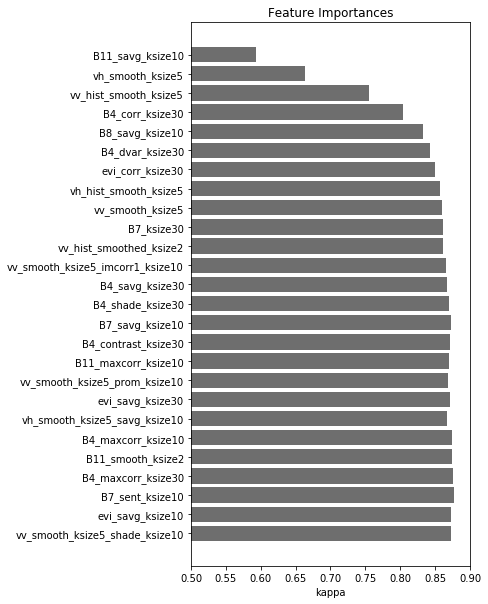

In [0]:
# PLOT FIGURE
features = selected_bands
importances = np.array(selectedKappa).copy()
indices = np.argsort(importances)

plt.rcParams['figure.figsize'] = [5, 10]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances, color='#6E6E6E', align='center')
plt.yticks(range(len(indices)), features)
plt.xlabel('kappa')
plt.xlim((0.5, 0.9))

# download image as svg
plt.savefig('fs2_sfs.svg')
files.download('fs2_sfs.svg')

# plt.show()


# PERMUTATION ANALYSIS (with Kappa Coefficient)

In [0]:
# import libraries
import random
import numpy as np
import pandas as pd

from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit  #from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import r2_score

import seaborn as sns
import graphviz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import GridSearchCV

In [0]:
# Prepare data
X = Xall.copy()
y = df.Class5.copy()
bands = Xall.columns.values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=0, random_state=35, verbose=0,
                       warm_start=False)


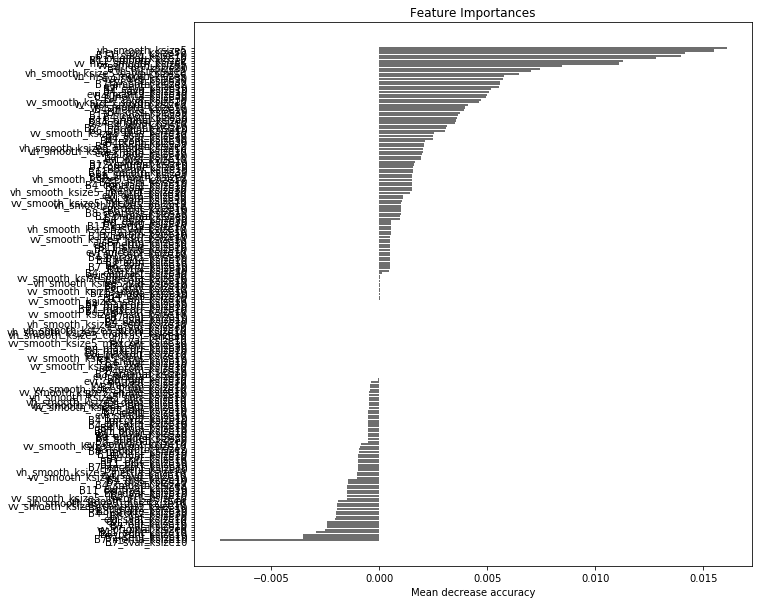

In [0]:
# MAKE PERMUTATION ANALYSIS
X1 = X[bands].copy().as_matrix()

bands = bands_completeName
# print(acc)
rf = RandomForestClassifier(n_estimators=50, random_state=35,min_samples_split=2,min_samples_leaf=3,max_features='sqrt',oob_score=0)
#rf = RandomForestRegressor(random_state=0)
print(rf)
scores = {}

for ii in range(0,10):
  jj = ii+1
  X_train = X1[folders==jj]
  Y_train = y[folders==jj]
  X_test = X1[folders!=jj]
  Y_test = y[folders!=jj]

  r = rf.fit(X_train, Y_train)
  acc = cohen_kappa_score(rf.predict(X_test), Y_test) #r2_score(Y_test, rf.predict(X_test))
  for i in range(X1.shape[1]):

      X_t = X_test.copy()
      np.random.shuffle(X_t[:, i])
      shuff_acc = cohen_kappa_score(rf.predict(X_t), Y_test) #r2_score(Y_test, rf.predict(X_t))
      scores[bands[i]] = ((acc-shuff_acc)/acc)
      
mda_features = [f for f in scores.keys()]
mda_importance = [(np.mean(score)) for score in scores.values()]
mda_indices = np.argsort(mda_importance)

# plot
plt.rcParams['figure.figsize'] = [10, 10]
plt.title('Feature Importances')
plt.barh(range(len(mda_indices)), [mda_importance[i] for i in mda_indices], color='#6E6E6E', align='center')
plt.yticks(range(len(mda_indices)), [mda_features[i] for i in mda_indices])
plt.xlabel('Mean decrease accuracy')
plt.show()



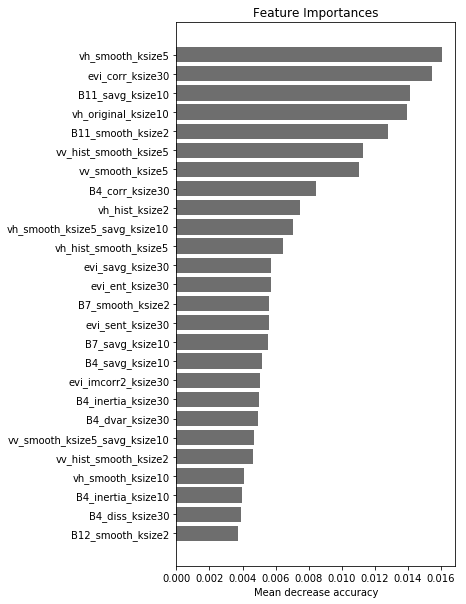

In [0]:
# plot only the 26 most relevant features
plt.rcParams['figure.figsize'] = [5, 10]
plt.title('Feature Importances')
plt.barh(range(26), [mda_importance[i] for i in mda_indices[-26:]], color='#6E6E6E', align='center')
plt.yticks(range(26), [mda_features[i] for i in mda_indices[-26:]])
plt.xlabel('Mean decrease accuracy')

# download image as svg
plt.savefig('fs3_perm.svg')
files.download('fs3_perm.svg')


# Mcneamer test

In [0]:

from statsmodels.stats.contingency_tables import mcnemar

In [0]:
# CROSS VALIDATION 1TRAIN 9TEST VS. 9TRAIN 1TEST

bands = allBands

PRED = np.empty((len(Xall[folders<6]),3,4,))
PRED[:] = np.nan

for bb in range(4):

  if bb == 0:
    bands = bandsS1
  elif bb == 1:
    bands = bandsS2
  elif bb == 2:
    # Bands from sequential feature selection
    bands = ['B11_savg', 't0_vh_smoothed2', 't0_vv_hist_smoothed2', 'B4_corr_1', 'B8_savg', 'B4_dvar_1',
             'evi_corr_1', 't0_vh_hist_smoothed2', 't0_vv_smoothed2', 'B7_1', 't0_vv_hist_smoothed',
             't0_vv_smoothed2_imcorr1', 'B4_savg_1', 'B4_shade_1', 'B7_savg']
  elif bb == 3:
    bands = bandsNoFeatures

  X = Xall[bands].copy()

  for cc in range(3):
    if cc == 0:
      y = df.Class5.copy()
    elif cc == 1:
      y = df.Class5.copy()
      y[y==2]=1
      y[y==4]=3    
    elif cc == 2:
      y = df.Class5.copy()
      y[y==2]=5
      y[y==4]=5
      y[y==3]=1   

    millis1 = int(round(time.time() * 1000))

    X_train = X[folders>=6]
    y_train = y[folders>=6]
    X_test = X[folders<6]
    y_test = y[folders<6]


    model = RandomForestClassifier(n_estimators=50, random_state=35,min_samples_split=2,min_samples_leaf=3,max_features='sqrt',oob_score=0,
                                  warm_start=True)
    model = model.fit(X_train, y_train)

    PRED[:,cc,bb] = model.predict(X_test)==y_test

    acc = model.score(X_test, y_test)

    millis2 = int(round(time.time() * 1000))

  

In [0]:
print('_____________________________')

classSetup = ['5-class setup','3-class setup','2-class setup']
bandSetup = ['S1 feat','S2 feat','S1&S2 no feat']

for cc in range(3):
  print(classSetup[cc])
  print(' ')
  
  for bb in range(3):
    print(bandSetup[bb])
    
    if bb==2:
      bb = bb+1

    pred1 = PRED[:,cc,2]
    pred2 = PRED[:,cc,bb]

    cell1 = np.sum((pred1==1) & (pred2==1))
    cell2 = np.sum((pred1==1) & (pred2==0))
    cell3 = np.sum((pred1==0) & (pred2==1))
    cell4 = np.sum((pred1==0) & (pred2==0))

    # define contingency table
    table = [[cell1, cell2],
         [cell3, cell4]]


    # calculate mcnemar test
    result = mcnemar(table, exact=True)
    # summarize the finding
    print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
    # interpret the p-value
    alpha = 0.05
    if result.pvalue > alpha:
      print('Same proportions of errors (fail to reject H0)')
    else:
      print('Different proportions of errors (reject H0)')
    print(' ')
    
  print(' ')
  print('_____________________________')


_____________________________
5-class setup
 
S1 feat
statistic=37.000, p-value=0.000
Different proportions of errors (reject H0)
 
S2 feat
statistic=55.000, p-value=0.000
Different proportions of errors (reject H0)
 
S1&S2 no feat
statistic=47.000, p-value=0.000
Different proportions of errors (reject H0)
 
 
_____________________________
3-class setup
 
S1 feat
statistic=42.000, p-value=0.000
Different proportions of errors (reject H0)
 
S2 feat
statistic=44.000, p-value=0.000
Different proportions of errors (reject H0)
 
S1&S2 no feat
statistic=41.000, p-value=0.000
Different proportions of errors (reject H0)
 
 
_____________________________
2-class setup
 
S1 feat
statistic=11.000, p-value=0.000
Different proportions of errors (reject H0)
 
S2 feat
statistic=40.000, p-value=0.000
Different proportions of errors (reject H0)
 
S1&S2 no feat
statistic=41.000, p-value=0.747
Same proportions of errors (fail to reject H0)
 
 
_____________________________
